In [4]:
import sys
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')


from math import sqrt
import pandas as pd

import torch
import torch.nn.functional as F
from rdkit import Chem

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn.models import AttentiveFP

In [5]:
from clsar.dataset import LSSNS # dataset
from clsar.feature import Gen115AtomFeatures, GenAttentiveFeatures # feature
from clsar.model import ACNet_GCN, ACNet_GIN, ACNet_GAT, ACNet_PNA # model

In [8]:
for dataset_name in LSSNS.names.keys():
    
    print(dataset_name)
    #dataset_name = 'plk1'
    Dataset =  LSSNS # MoleculeNet
    epochs = 500

    pre_transform = Gen115AtomFeatures()
    in_channels = 115
    path = '/home/shenwanxiang/tmp/data3'

    dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle()

    batch_size = 16

    # train, valid, test splitting
    N = len(dataset) // 5
    val_dataset = dataset[:N]
    test_dataset = dataset[N:2 * N]
    train_dataset = dataset[2 * N:]


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ur2


Processing...
Done!
Processing...


plk1


Done!
Processing...


rip2


Done!
Processing...


rorg


Done!
Processing...


klk5


Done!
Processing...


braf


Done!
Processing...


usp7


Done!
Processing...


phgdh


Done!
Processing...


notum


Done!
Processing...


rxfp1


Done!
Processing...


mglur2


Done!
Processing...


pkci


Done!
Processing...


eaat3


Done!


In [9]:
## 4 kind of models
pub_args = {'in_channels':115, 'hidden_channels':64, 'out_channels':1,
            'edge_dim':10, 'num_layers':2, 'dropout_p':0.2, 'batch_norms':None}

model_1 = ACNet_GCN(**pub_args).to(device)

model_2 = ACNet_GIN(**pub_args, eps = 0.0, train_eps = False).to(device)

model_3 = ACNet_GAT(**pub_args, dropout = 0.1, heads=3).to(device)

model_4 = ACNet_PNA(**pub_args, aggregators = ['mean', 'max', 'sum'],
                    scalers = ['identity', 'amplification'], 
                    deg = torch.tensor([1, 2, 3]),
                   ).to(device)

In [10]:
res = {}
for model, name in zip([model_1, model_2, model_3, model_4],['ACNet_GCN', 'ACNet_GIN', 'ACNet_GAT', 'ACNet_PNA']):

    print(name, '#'*50)
    
    def train(train_loader):
        total_loss = total_examples = 0
        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out, embed = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
            loss = F.mse_loss(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += float(loss) * data.num_graphs
            total_examples += data.num_graphs
        return sqrt(total_loss / total_examples)

    @torch.no_grad()
    def test(loader):
        mse = []
        for data in loader:
            data = data.to(device)
            out, embed = model(data.x.float(), data.edge_index, data.edge_attr, data.batch)
            mse.append(F.mse_loss(out, data.y, reduction='none').cpu())
        return float(torch.cat(mse, dim=0).mean().sqrt())

    optimizer = torch.optim.Adam(model.parameters(), lr=10**-3.5,
                                 weight_decay=10**-5)
    history = []
    for epoch in range(1, epochs):
        train_rmse = train(train_loader)
        val_rmse = test(val_loader)
        test_rmse = test(test_loader)
        print(f'Epoch: {epoch:03d}, Loss: {train_rmse:.4f} Val: {val_rmse:.4f} '
              f'Test: {test_rmse:.4f}')

        history.append({'Epoch':epoch, 'train_rmse':train_rmse, 'val_rmse':val_rmse, 'test_rmse':test_rmse})
        
    print('\n')
    res.update({name:history})

ACNet_GCN ##################################################
Epoch: 001, Loss: 1.2502 Val: 1.8611 Test: 1.3129
Epoch: 002, Loss: 1.5764 Val: 1.0292 Test: 1.3655
Epoch: 003, Loss: 1.2133 Val: 1.3740 Test: 1.9207
Epoch: 004, Loss: 1.2487 Val: 1.1122 Test: 1.3174
Epoch: 005, Loss: 1.1448 Val: 0.8103 Test: 1.0613
Epoch: 006, Loss: 1.2675 Val: 0.9505 Test: 1.3364
Epoch: 007, Loss: 1.2006 Val: 0.9334 Test: 1.2783
Epoch: 008, Loss: 0.9282 Val: 1.1126 Test: 1.3076
Epoch: 009, Loss: 1.0617 Val: 1.1288 Test: 1.5831
Epoch: 010, Loss: 1.1070 Val: 0.6932 Test: 1.3252
Epoch: 011, Loss: 1.1897 Val: 1.2122 Test: 1.4032
Epoch: 012, Loss: 1.0684 Val: 1.0258 Test: 1.2395
Epoch: 013, Loss: 1.1359 Val: 1.2715 Test: 1.4352
Epoch: 014, Loss: 1.1358 Val: 1.0558 Test: 1.0954
Epoch: 015, Loss: 1.0841 Val: 1.3226 Test: 0.9628
Epoch: 016, Loss: 0.9451 Val: 0.9858 Test: 1.0410
Epoch: 017, Loss: 1.0325 Val: 1.0296 Test: 1.2539
Epoch: 018, Loss: 1.0259 Val: 1.1437 Test: 1.3978
Epoch: 019, Loss: 0.9889 Val: 1.0588 Te

<AxesSubplot:>

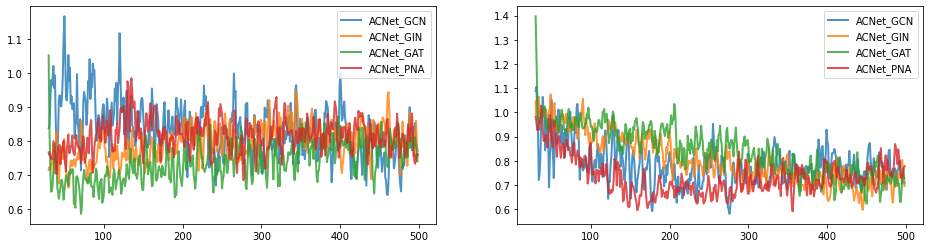

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(res)

fig, axes = plt.subplots(ncols = 2, figsize=(16, 4))

(ax1, ax2) = axes
test_rmse = pd.concat(df.apply(lambda x:x.apply(pd.Series).test_rmse.to_frame(name = x.name), axis=1).to_list(), axis=1).T
val_rmse = pd.concat(df.apply(lambda x:x.apply(pd.Series).val_rmse.to_frame(name = x.name), axis=1).to_list(), axis=1).T

val_rmse.rolling(3).mean().iloc[30:].plot(ax = ax1, lw=2, alpha=0.8)

test_rmse.rolling(3).mean().iloc[30:].plot(ax = ax2, lw=2, alpha=0.8)